<a href="https://colab.research.google.com/github/Waidhoferj/CSC-566-Project/blob/heatmaps/FacialLandmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Landmarks
Experimentation with facial landmarks models and datasets.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
import os
from scipy.io import loadmat
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Add your name and filepath to the project folder so that you can load the datasets.


In [10]:
USER = "Jeremy-local"
USER_FILEPATHS = {
    "John" : "/content/drive/MyDrive/CSC 566 Project",
    "Jeremy-local": "C:/Users/Jeremy/Downloads/CSC-566-Project",
    "Jeremy" : "/content/drive/MyDrive/School/Undergrad/2021 Spring/CSC 566/CSC 566 Project",
    "Ty" : "/content/drive/MyDrive/CSC 566 Project"
}
PROJECT_FILEPATH = USER_FILEPATHS[USER]

## Data Preparation

In [11]:
# Sanity check for loading data
def display_landmarks(img, points):
  """
  Displays portrait with landmark dots drawn on the face.
  Assumes that points are in (68,2)
  """
  #If we are reading from .mat files directly (2,68)
  if points.shape[0] == 2:
    points = points.transpose(1,0)
  #If reading from model output
  elif len(points.shape) == 1:
    points = points.reshape(-1,2)
  fig,ax = plt.subplots(1)
  ax.set_aspect('equal')
  ax.imshow(img)
  for p in points:
      circ = Circle(p)
      ax.add_patch(circ)
  plt.show()

#points = loadmat(AFW_DATASET + "/70037463_1.mat")["pt2d"]
#img  = plt.imread( AFW_DATASET+"/70037463_1.jpg")

#display_landmarks(img,points)



In [12]:
import tensorflow as tf

USE_CROPPED_IMAGES = True
USE_HEATMAPS = True

DATALOADER_BASE_PATH = PROJECT_FILEPATH + "/datasets/tf-datasets"
DATASET_PREFIX = "cropped-" if USE_CROPPED_IMAGES else ""

class DataLoader:

  IMAGE_SHAPE = (256, 256, 3) if USE_CROPPED_IMAGES else (450, 450, 3)
  LANDMARKS_SHAPE = (136,)

  HEATMAP_SHAPE = (64, 64)
  HEATMAP_POINT_RADIUS = 0.15

  BATCH_SIZE = 64
  TRAIN_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}train-{i}.tfrecord.gz" for i in range(5)]
  VAL_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}val-{i}.tfrecord.gz" for i in range(5)]
  TEST_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}test-{i}.tfrecord.gz" for i in range(5)]

  def load_datasets():
    dl = DataLoader()
    return (dl.__load_dataset(DataLoader.TRAIN_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.VAL_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.TEST_PATHS, 1))

  def __load_dataset(self, filepath, batch_size):
    dataset = tf.data.TFRecordDataset([filepath], compression_type="GZIP")
    dataset = dataset.map(self.__parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(self.__reshape_entry, num_parallel_calls=tf.data.AUTOTUNE)

    if USE_HEATMAPS:
      imagesToHeatmapsDataset, heatmapsToPointsDataset = self.__convert_to_heatmaps(dataset, batch_size)
      imagesToHeatmapsDataset.cache()
      heatmapsToPointsDataset.cache()
      return imagesToHeatmapsDataset, heatmapsToPointsDataset
    else:
      images = dataset.map(lambda x,y: x, num_parallel_calls=tf.data.AUTOTUNE)
      labels = dataset.map(lambda x,y: y, num_parallel_calls=tf.data.AUTOTUNE)
      images = images.batch(batch_size)
      labels = labels.batch(batch_size)
      dataset = tf.data.Dataset.zip((images, labels))
      dataset.cache() # Cache the above map operations so they aren't re-run every epoch
    return dataset


  def __parse_example(self, record):
    feature_names = {}
    feature_names['image'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    feature_names['landmarks'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    return tf.io.parse_single_example(record, feature_names)

  def __reshape_entry(self, entry):
    image = tf.reshape(entry['image'], DataLoader.IMAGE_SHAPE)
    landmarks = tf.reshape(entry['landmarks'], DataLoader.LANDMARKS_SHAPE)
    return image, landmarks

  def __convert_to_heatmaps(self, dataset, batch_size):
    images = dataset.map(lambda x,y: x, num_parallel_calls=tf.data.AUTOTUNE)
    labels = dataset.map(lambda x,y: y, num_parallel_calls=tf.data.AUTOTUNE)

    heatmaps = labels.map(self.__convert_label_to_heatmap, num_parallel_calls=tf.data.AUTOTUNE)
    heatmaps = heatmaps.batch(batch_size)

    imagesToHeatmaps = tf.data.Dataset.zip((images.batch(batch_size), heatmaps))
    heatmapsToPoints = tf.data.Dataset.zip((heatmaps, labels.batch(batch_size)))

    return imagesToHeatmaps, heatmapsToPoints

  @tf.autograph.experimental.do_not_convert
  def __convert_label_to_heatmap(self, label):
    heatmap = tf.zeros(DataLoader.HEATMAP_SHAPE)
    coords = tf.range(DataLoader.HEATMAP_SHAPE[0]*DataLoader.HEATMAP_SHAPE[1], dtype=tf.float32)
    coords = tf.reshape(coords, DataLoader.HEATMAP_SHAPE)
    for i in range(0, 68):
      heatmap += self.__add_point_to_heatmap(coords, label[2*i], label[2*i+1])
    return tf.math.maximum(np.zeros(heatmap.shape, dtype=np.float32), tf.math.minimum(np.ones(heatmap.shape, dtype=np.float32), heatmap))

  @tf.autograph.experimental.do_not_convert
  def __add_point_to_heatmap(self, coords, x, y):
    return tf.map_fn(fn=lambda i: self.__heatmap_point_dist(i, x, y, coords.shape[0], coords.shape[1]), elems=coords)

  @tf.autograph.experimental.do_not_convert
  def __heatmap_point_dist(self, i, x, y, w, h):
    ix = (i%h)/w
    iy = (i//h)/h
    radius = DataLoader.HEATMAP_POINT_RADIUS
    dist = tf.sqrt((x-ix)**2 + (y-iy)**2)
    return tf.math.minimum(1.0, tf.math.maximum(0.0, 1.0 - (1/radius)*dist))


train_data, val_data, test_data = DataLoader.load_datasets()

#val_1st, val_2nd = val_data
#
#for i,record in enumerate(val_2nd):
#  print(record[0].shape, record[1].shape)
#  plt.gray()
#  plt.imshow(record[0][0])
#  break

# Heatmap To Landmarks CNN


In [24]:
def create_heatmap_to_points_cnn(input_shape, output_shape):
  input_layer = layers.Input(input_shape)
  x = input_layer

  x = layers.Reshape((input_shape[0], input_shape[1], 1))(x)

  features = 16
  for i in range(1):
    x = layers.Conv2D(features, (3,3), 1, activation="relu")(x)
    x = layers.MaxPool2D(padding="same")(x)
    features *= 2

  x = layers.Flatten()(x)
  x = layers.Dense(512, activation="relu")(x)
  x = layers.Dense(output_shape[0], activation="relu")(x)
  return Model(name="heatmap_to_landmarks", inputs=input_layer, outputs=x)


heatmap_to_points_model = create_heatmap_to_points_cnn(DataLoader.HEATMAP_SHAPE, DataLoader.LANDMARKS_SHAPE)
heatmap_to_points_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.003), loss="mse", metrics=["accuracy"])
heatmap_to_points_model.summary()

Model: "heatmap_to_landmarks"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64)]          0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 15376)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               7873024   
_________________________________________________________________
dense_7 (Dense)              (None, 136)      

In [42]:
_, train_ds = train_data
_, val_ds = val_data

#for i,record in enumerate(train_ds):
#  print(record[0].shape, record[1].shape)
#  plt.gray()
#  plt.imshow(record[0][0])
#  break

#heatmap_to_points_model.fit(train_ds.shuffle(64), epochs=30, validation_data=val_ds, verbose=1)
heatmap_to_points_model.fit(train_ds.shuffle(64), epochs=100, validation_data=val_ds, verbose=1)

Epoch 1/100
26/26 [==============================] - 31s 374ms/step - loss: 0.6298 - accuracy: 0.2615 - val_loss: 0.4149 - val_accuracy: 0.2920
Epoch 2/100
26/26 [==============================] - 31s 373ms/step - loss: 0.6293 - accuracy: 0.2554 - val_loss: 0.4159 - val_accuracy: 0.2720
Epoch 3/100
26/26 [==============================] - 32s 381ms/step - loss: 0.6292 - accuracy: 0.2560 - val_loss: 0.4146 - val_accuracy: 0.3120
Epoch 4/100
26/26 [==============================] - 32s 394ms/step - loss: 0.6290 - accuracy: 0.2702 - val_loss: 0.4149 - val_accuracy: 0.3120
Epoch 5/100
26/26 [==============================] - 31s 374ms/step - loss: 0.6288 - accuracy: 0.2628 - val_loss: 0.4142 - val_accuracy: 0.3240
Epoch 6/100
26/26 [==============================] - 31s 371ms/step - loss: 0.6284 - accuracy: 0.2763 - val_loss: 0.4132 - val_accuracy: 0.3600
Epoch 7/100
26/26 [==============================] - 31s 381ms/step - loss: 0.6279 - accuracy: 0.2585 - val_loss: 0.4129 - val_accuracy:

KeyboardInterrupt: ignored

In [35]:
heatmap_to_points_model.optimizer.learning_rate.assign(0.03)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.01>

<AxesSubplot:>

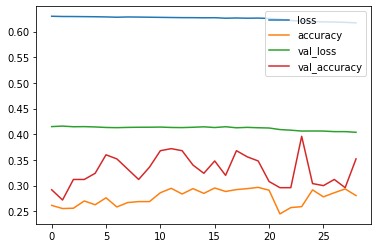

In [43]:
pd.DataFrame(heatmap_to_points_model.history.history).plot()

In [40]:
heatmap_to_points_model.evaluate(test_data[1])

443/443 [==============================] - 10s 13ms/step - loss: 0.5316 - accuracy: 0.2822


[0.5316447019577026, 0.2821670472621918]

In [41]:
heatmap_to_points_model.save_weights(PROJECT_FILEPATH + "/heatmap-to-points-model-2.h5")

## Basic Benchmark Model
From [this medium article](https://towardsdatascience.com/detecting-facial-features-using-deep-learning-2e23c8660a7a)

In [44]:
def pad_to_fit(x, target_shape):
  padding_list = [[0, target_shape[dim] - x.shape[dim]] for dim in range(1, len(target_shape))] # skip batch dim which is None
  padding_list = [[0,0]] + padding_list # add the first (batch) dimension manually so it doesn't do (None - None)
  padding = tf.constant(padding_list)
  return tf.pad(x, padding, "REFLECT") # TODO change padding method to reflect or symmetric

def create_basic_landmark_model(input_shape, conv_range):
  input_layer = layers.Input(input_shape)
  x = input_layer
  encoder_stack = []
  for exp in conv_range:
    x = layers.Conv2D(2**exp, (3,3), 1, activation="relu", padding='same')(x)
    encoder_stack.append(x)
    x = layers.MaxPool2D(padding="same")(x)
  for exp in conv_range[2:][::-1]:
    encoder = encoder_stack.pop()
    x = layers.Conv2DTranspose(2**exp, (3,3), strides=(2,2), padding='same')(x)
    x = layers.concatenate([encoder, pad_to_fit(x, encoder.shape)])

  x = layers.Conv2D(1, (3,3), 1, activation="linear", padding="same")(x)
  #x = layers.Flatten()(x)
  #x = layers.Dense(500, activation="relu")(x)
  #x = layers.Dense(90, activation="relu")(x)
  #x = layers.Dense(68*2, activation="relu")(x)
  return Model(name="landmark_locator", inputs=input_layer, outputs=x)



In [45]:
INPUT_SHAPE = (256,256,3)
basic_model = create_basic_landmark_model(INPUT_SHAPE, range(5,8))
basic_model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
basic_model.summary()

Model: "landmark_locator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 64) 18496       max_pooling2d_6[0][0]            
___________________________________________________________________________________

In [48]:
basic_model.load_weights(PROJECT_FILEPATH + "/basic-model-to-heatmap.h5")

In [9]:
#basic_model.fit(train_data[0].shuffle(64), epochs=40, validation_data=val_data[0], verbose=1)
basic_model.fit(train_data[0].shuffle(64), epochs=20, verbose=1)

Epoch 1/20
26/26 [==============================] - 208s 199ms/step - loss: 0.2254 - accuracy: 0.4347
Epoch 2/20
26/26 [==============================] - 197s 147ms/step - loss: 0.1733 - accuracy: 0.5272
Epoch 3/20
26/26 [==============================] - 196s 146ms/step - loss: 0.1541 - accuracy: 0.5616
Epoch 4/20
26/26 [==============================] - 192s 146ms/step - loss: 0.1506 - accuracy: 0.5658
Epoch 5/20
26/26 [==============================] - 197s 146ms/step - loss: 0.1457 - accuracy: 0.5755
Epoch 6/20
26/26 [==============================] - 197s 150ms/step - loss: 0.1369 - accuracy: 0.5848
Epoch 7/20
26/26 [==============================] - 195s 146ms/step - loss: 0.1354 - accuracy: 0.5884
Epoch 8/20
26/26 [==============================] - 195s 146ms/step - loss: 0.1355 - accuracy: 0.5870
Epoch 9/20
26/26 [==============================] - 195s 147ms/step - loss: 0.1352 - accuracy: 0.5879
Epoch 10/20
26/26 [==============================] - 198s 146ms/step - loss: 0.134

In [18]:
basic_model.save_weights(PROJECT_FILEPATH + "/basic-model-to-heatmap.h5")

### Analyze Results

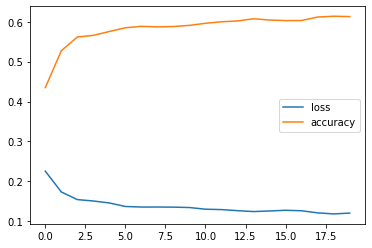

In [10]:
pd.DataFrame(basic_model.history.history).plot()

In [66]:
predictions = basic_model.predict(test_data[0].map(lambda x,y: x))
landmark_predictions = heatmap_to_points_model.predict(predictions)#(test_data[1].map(lambda x,y: x))
landmark_predictions *= 256

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


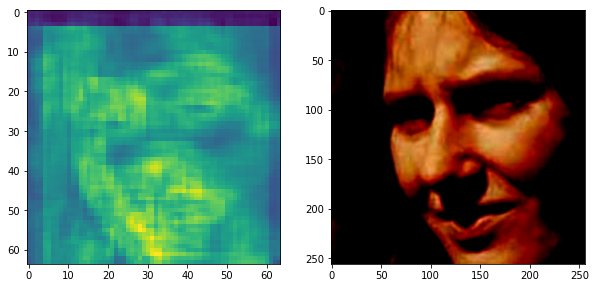

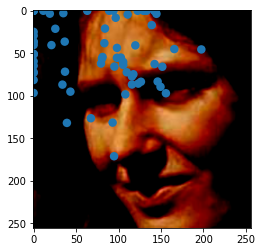

In [67]:
#@title View Predicted Images
image_index = 3 #@param {type:"slider", min:1, max:16, step:1}
points = predictions * 450
i = 0
fig = plt.figure(figsize=(10,10))
for x in test_data[0].map(lambda x,y: x):
  if (i == image_index):
    fig.add_subplot(1, 2, 1)
    plt.imshow(np.reshape(predictions[i], (64, 64)))
    fig.add_subplot(1, 2, 2)
    plt.imshow(x[0])
    display_landmarks(x[0], landmark_predictions[image_index])
    break
  i += 1